# Mountain Car Miniproject Tutorial Notebook

This notebook is here to guide you through the basics of the frameworks necessary for you to do well on your CS456-Miniproject 🤓

In [2]:
import gymnasium as gym
import numpy as np
import matplotlib.pyplot as plt
import torch

## Gymnasium environments

One of the main and most spread environment developer in the field of RL research is [Gymnasium](https://gymnasium.farama.org/). They provide standardized environments offering a large range of difficulties and setups, that are perfectly designed to benchmark performances of RL and Deep RL algorithms.

The main structure is very simple to understand. First, we need to instantiate our environment. We will use an existing environment, but one could also use their structure to design their own environment.

Let's directly work with the Mountain Car environment that will be used in the project. 

_PS: If you're more curious, feel free to browse the large list available on their website!_

In [3]:
env = gym.make('MountainCar-v0')

(array([-0.518167,  0.      ], dtype=float32), {})

The environment contains an action space and an observation (state) space. Let's see what these look like.

In [3]:
print(f"Action space: {env.action_space}")
print(f"Observation space: {env.observation_space}") 

Action space: Discrete(3)
Observation space: Box([-1.2  -0.07], [0.6  0.07], (2,), float32)


In [4]:
print(f"Number of actions available: {env.action_space.n}")
print(f"Observation shape: {env.observation_space.shape}")

Number of actions available: 3
Observation shape: (2,)


As we can see, the action space of that first environment is discrete and contains 3 possible actions: accelerate to the left, don't accelerate and accelerate to the right. 

The observation space has a dimension of 2, and you can find what each part represents [here](https://gymnasium.farama.org/environments/classic_control/mountain_car/#observation-space). 
(position of the car along the x-axis, velocity of the car)



Before taking actions, the environment should be reset (or boostrapped). **Note: this should be done every time the environment has to be restarted, i.e., at the end of any episode.**

In [16]:
# the second return value is an info dictionary, but it doesn't contain anything in this environment
starting_state, _ = env.reset() 

print(f"Starting state: {starting_state}")

Starting state: [-0.4625258  0.       ]


Now that we know what the actions look like and that the environment is ready, we can take actions inside it. This is done using the `env.step` function, that takes an action as input, and returns multiple values. More details on each of them can be found [here](https://gymnasium.farama.org/api/env/#gymnasium.Env.step).

In the project, you will have an agent that will choose an action (based on the policy learned) given the current state. However, for now, we can simply sample actions at random using `action_space.sample()`.

In [17]:
action = env.action_space.sample()    # random action
print(f"Sampled action: {action}")
next_state, reward, terminated, truncated, _ = env.step(action) # again, the last return value is an empty info object

print(f"Next state: {next_state}")
print(f"Reward: {reward}")
print(f"Terminated: {terminated}")
print(f"Truncated: {truncated}")

Sampled action: 2
Next state: [-0.4619813   0.00054451]
Reward: -1.0
Terminated: False
Truncated: False


The `terminated` and `truncated`  variables represent the two ways that the episode might be done. Thus, it might be handy to use
```
done = terminated or truncated
```
in your code. 💡

We now have all the pieces necessary to run a full episode!

In [18]:
done = False
state, _ = env.reset()
episode_reward = 0

while not done: #while not false:
    action = env.action_space.sample()
    next_state, reward, terimnated, truncated, _ = env.step(action)

    episode_reward += reward

    state = next_state
    done = terminated or truncated #Updates the done flag to indicate whether the episode is terminated (terminated == True) or truncated (truncated == True).

print(f"Episode reward after taking random actions: {episode_reward}")

Episode reward after taking random actions: -200.0


Now your goal in the project will be to code an agent that can beat that 🙃

## I. First steps

We will start by gaining intuition on the task at hand by running a random agent. Create a RandomAgent, which selects actions randomly. Run the agent on the environment until the episode is either truncated or terminated. Store the episode and render (visualize) it.

Now run the agent for 100 episodes. At every episode initialize the environment with a new randomly sampled seed. Plot the duration of each episode as a scatter plot. What do you find? Explain.

In [6]:
class RandomAgent:
    def __init__(self, env):
        self.env = env
        self.alpha = 0.1  # Learning rate
        self.gamma = 0.99  # Discount factor
        self.epsilon = 0.1  # Epsilon for epsilon-greedy policy

    def select_action(self, state):
        return self.env.action_space.sample()  # Random action

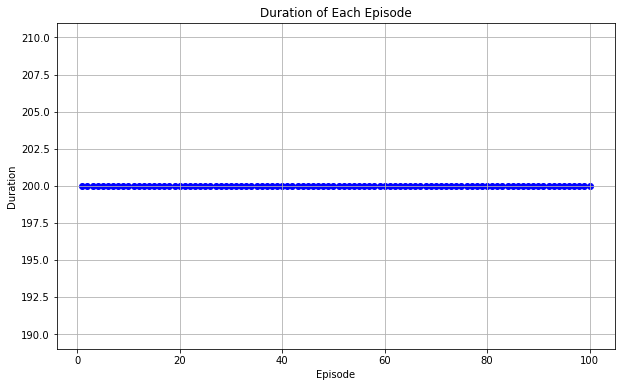

In [13]:
# Function to run the agent for a given number of episodes
def run_random_agent(agent, num_episodes):
    episode_durations = []

    for episode in range(num_episodes):
        state, _ = env.reset()    # is this enough to initialize environment with randomly sampled seed
        
        episode_reward = 0
        done = False
        duration = 0

        while not done:
            action = agent.select_action(state)
            next_state, reward, terminated, truncated, _ = env.step(action)
            episode_reward += reward
            duration += 1
            state = next_state
            done = terminated or truncated

        episode_durations.append(duration)
        #print(f"Episode {episode + 1}: Duration {duration}, Total Reward {episode_reward}")

        
    return episode_durations

# Create an environment
env = gym.make('MountainCar-v0')

# Create a RandomAgent
random_agent = RandomAgent(env)

# Run the agent for 100 episodes
episode_durations = run_random_agent(random_agent, 100)

# Close the environment
env.close()

# Plot the duration of each episode as a scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(range(1, 101), episode_durations, marker='o', color='b')
plt.xlabel('Episode')
plt.ylabel('Duration')
plt.title('Duration of Each Episode')
plt.grid(True)
plt.show()

## II. DQN 

In [36]:
class RLAgent:
    def __init__(self, env):
        self.env = env
        self.Q_table = np.zeros((env.observation_space.shape[0], env.action_space.n))
        self.alpha = 0.1  # Learning rate
        self.gamma = 0.99  # Discount factor
        self.epsilon = 0.1  # Epsilon for epsilon-greedy policy
        self.replay_buffer = []
        
    def observe(self, state, action, next_state, reward): #called upon observing a new transition of the environment.
        self.replay_buffer.append((state, action, next_state, reward))
        
    def select_action(self, state): #pick an action from the given state.
        # Epsilon-greedy policy
        if np.random.rand() < self.epsilon:
            return self.env.action_space.sample()  # Random action
        else:
            return np.argmax(self.Q_table[state])  # Greedy action
    
    def update(self): #called after each environment step. This is whereall the training takes place.
        # Update Q-value using Q-learning update rule
        td_target = reward + self.gamma * np.max(self.Q_table[next_state])    # target value for updating the Q-value of a state-action pair. 
        td_error = td_target - self.Q_table[state, action]   #difference between the target Q-value and the current estimate of the Q-value for a state-action pair
        self.Q_table[state, action] += self.alpha * td_error
        
        
        
        

## III. DYNA